In [22]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch.amp import autocast, GradScaler
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchmetrics

In [23]:
seed = 333
torch.random.manual_seed(seed)

device="cuda"

batch_size = 4

root_path = "/home/stefan/ioai-prep/kits/roai-2025/skeletons"

# Data preparation

In [24]:
class MovementDataset(Dataset):
    def __init__(self, df_path: str):
        self.df = pd.read_csv(df_path)

        self.unique_ids = self.df["IDSample"].nunique()
        self.start_idx = self.df.iloc[0]["IDSample"]

    def len_frames(self, idx):
        row_idx = int(idx + self.start_idx)
        rows = self.df[self.df["IDSample"] == row_idx]
        return len(rows)
    
    def __getitem__(self, idx):
        row_idx = int(idx + self.start_idx)
        rows = self.df[self.df["IDSample"] == row_idx]
        length = len(rows)

        cols = [f"J{i}X" for i in range(1, 25+1)] + [f"J{i}Y" for i in range(1, 25+1)] + [f"J{i}Z" for i in range(1, 25+1)]
        data = rows[cols].values.reshape(-1, 25 * 3)
        data = torch.tensor(data, dtype=torch.float32)

        if "Camera" in rows:
            labels = rows.iloc[0][["Camera", "Action"]].values
            labels[0] -= 1  # zero-index cameras
            labels = torch.tensor(labels, dtype=torch.long).reshape(1, 2)

            return data, length, labels
        return data, length
    
    def __len__(self):
        return self.unique_ids

In [25]:
def collate_fn(batch):
    data, lengths, labels = zip(*batch)
    lengths = torch.tensor(lengths, dtype=torch.long)
    # pad sequences (batch_size, max_seq_len, feat_dim)
    data_padded = pad_sequence(data, batch_first=True)
    labels = torch.stack(labels, dim=0)
    return data_padded, lengths, labels

In [26]:
full_dataset = MovementDataset(f"{root_path}/train_data.csv")
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
dataloader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [27]:
batch = next(iter(dataloader_train))

# (batch_size, seq_len, 75); (batch_size); (batch_size, 1, 2)
# data; lengths; labels
[b.shape for b in batch]

[torch.Size([4, 98, 75]), torch.Size([4]), torch.Size([4, 1, 2])]

# Model

In [28]:
class SkeletonNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.n_hidden = 128
        self.n_layers = 2

        self.lstm = nn.LSTM(input_size=75, hidden_size=self.n_hidden, num_layers=self.n_layers, batch_first=True)
        
        self.head = nn.LazyLinear(num_classes)

    def forward(self, x, lengths):
        # pack padded sequence
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.lstm(packed)
        
        # unpack
        output, _ = pad_packed_sequence(packed_out, batch_first=True)
        
        # compute mean over true lengths
        feats = torch.stack([output[i, :lengths[i]].mean(dim=0) for i in range(x.size(0))], dim=0)

        logits = self.head(feats)
        return logits

In [29]:
model_action = SkeletonNet(5).to(device)
model_camera = SkeletonNet(3).to(device)

data, length = batch[0].to(device), batch[1].to(device)
model_camera(data, length).shape

torch.Size([4, 3])

# Training

In [30]:
should_train = True

In [31]:
lr = 2e-4
losses = []

action_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=5).to(device)
camera_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=3).to(device)

scaler = GradScaler(device)

In [32]:
def train(model, is_camera: bool):
    label_idx = 0 if is_camera else 1
    accuracy = camera_accuracy if is_camera else action_accuracy
    label_acc = "camera_acc" if is_camera else "action_acc"

    patience, so_far = 7, 0
    best_acc = 0
    epochs = 40 if is_camera else 20

    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=epochs, eta_min=1e-6)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        # training
        for i, (data, length, labels) in enumerate(tqdm(dataloader_train, desc=f"Training Epoch {epoch+1}")):
            data, length, labels = data.to(device), length.to(device), labels.to(device)
            optimizer.zero_grad()

            # forward pass
            with autocast(device):
                logits = model(data, length)
                loss = criterion(logits, labels[:, 0, label_idx])

            # backward pass
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), 2.5)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step(epoch+1)

            # stats
            running_loss += loss.item()
            losses.append(loss.item())

        # validation
        model.eval()
        accuracy.reset()

        with torch.no_grad():
            for data, lengths, labels in dataloader_val:
                data, lengths, labels = data.to(device), lengths.to(device), labels.to(device)

                logits = model(data, lengths)
                accuracy(logits, labels[:, 0, label_idx])

        l = running_loss / len(dataloader_train)
        acc = accuracy.compute()

        # early stopping
        if acc > best_acc:
            best_acc = acc
            so_far = 0
        else:
            so_far += 1
            if so_far == patience:
                break

        print(f"Epoch {epoch+1}: loss={l:.2f} | {label_acc}={(acc*100):.1f}%")

In [33]:
def prep_model(model, is_camera: bool):
    if should_train:
        print("Training the model!")
        train(model, is_camera)
        torch.save(model.state_dict(), "model.pth")
    else:
        print("Loading the model!")
        model.load_state_dict(torch.load("model.pth"))

Training the model!


Training Epoch 1: 100%|██████████| 670/670 [00:11<00:00, 59.35it/s]


Epoch 1: loss=1.22 | action_acc=62.7%


Training Epoch 2: 100%|██████████| 670/670 [00:11<00:00, 58.45it/s]


Epoch 2: loss=0.75 | action_acc=83.5%


Training Epoch 3: 100%|██████████| 670/670 [00:11<00:00, 58.45it/s]


Epoch 3: loss=0.51 | action_acc=91.5%


Training Epoch 4: 100%|██████████| 670/670 [00:11<00:00, 57.70it/s]


Epoch 4: loss=0.39 | action_acc=93.0%


Training Epoch 5: 100%|██████████| 670/670 [00:11<00:00, 57.94it/s]


Epoch 5: loss=0.32 | action_acc=93.3%


Training Epoch 6: 100%|██████████| 670/670 [00:11<00:00, 58.41it/s]


Epoch 6: loss=0.27 | action_acc=94.9%


Training Epoch 7: 100%|██████████| 670/670 [00:11<00:00, 59.55it/s]


Epoch 7: loss=0.23 | action_acc=93.6%


Training Epoch 8: 100%|██████████| 670/670 [00:11<00:00, 58.83it/s]


Epoch 8: loss=0.22 | action_acc=94.6%


Training Epoch 9: 100%|██████████| 670/670 [00:11<00:00, 59.81it/s]


Epoch 9: loss=0.19 | action_acc=95.2%


Training Epoch 10: 100%|██████████| 670/670 [00:11<00:00, 58.71it/s]


Epoch 10: loss=0.18 | action_acc=96.4%


Training Epoch 11: 100%|██████████| 670/670 [00:11<00:00, 59.06it/s]


Epoch 11: loss=0.16 | action_acc=97.5%


Training Epoch 12: 100%|██████████| 670/670 [00:11<00:00, 60.47it/s]


Epoch 12: loss=0.12 | action_acc=96.6%


Training Epoch 13: 100%|██████████| 670/670 [00:11<00:00, 59.99it/s]


Epoch 13: loss=0.11 | action_acc=98.1%


Training Epoch 14: 100%|██████████| 670/670 [00:11<00:00, 60.11it/s]


Epoch 14: loss=0.09 | action_acc=97.5%


Training Epoch 15: 100%|██████████| 670/670 [00:11<00:00, 59.94it/s]


Epoch 15: loss=0.08 | action_acc=97.3%


Training Epoch 16: 100%|██████████| 670/670 [00:11<00:00, 58.61it/s]


Epoch 16: loss=0.06 | action_acc=98.1%


Training Epoch 17: 100%|██████████| 670/670 [00:11<00:00, 59.43it/s]


Epoch 17: loss=0.06 | action_acc=98.1%


Training Epoch 18: 100%|██████████| 670/670 [00:11<00:00, 60.62it/s]


Epoch 18: loss=0.05 | action_acc=98.1%


Training Epoch 19: 100%|██████████| 670/670 [00:11<00:00, 60.28it/s]


Epoch 19: loss=0.05 | action_acc=98.2%


Training Epoch 20: 100%|██████████| 670/670 [00:11<00:00, 59.44it/s]


Epoch 20: loss=0.05 | action_acc=97.9%


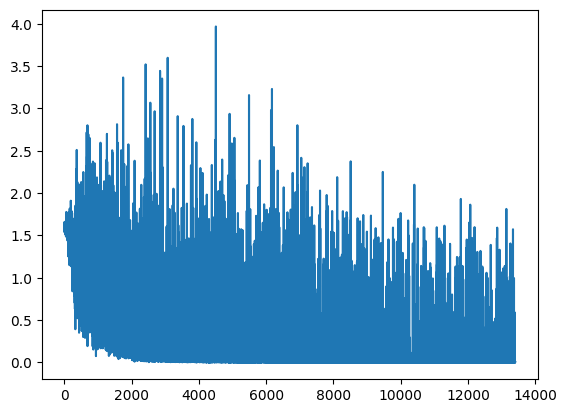

In [34]:
losses = []

prep_model(model_action, is_camera=False)
plt.plot(losses)

Training the model!


Training Epoch 1: 100%|██████████| 670/670 [00:11<00:00, 59.58it/s]


Epoch 1: loss=1.04 | camera_acc=47.4%


Training Epoch 2: 100%|██████████| 670/670 [00:10<00:00, 61.09it/s]


Epoch 2: loss=0.99 | camera_acc=47.7%


Training Epoch 3: 100%|██████████| 670/670 [00:11<00:00, 60.20it/s]


Epoch 3: loss=0.97 | camera_acc=54.4%


Training Epoch 4: 100%|██████████| 670/670 [00:11<00:00, 59.70it/s]


Epoch 4: loss=0.92 | camera_acc=49.5%


Training Epoch 5: 100%|██████████| 670/670 [00:11<00:00, 59.22it/s]


Epoch 5: loss=0.90 | camera_acc=55.4%


Training Epoch 6: 100%|██████████| 670/670 [00:11<00:00, 58.59it/s]


Epoch 6: loss=0.84 | camera_acc=59.2%


Training Epoch 7: 100%|██████████| 670/670 [00:11<00:00, 58.15it/s]


Epoch 7: loss=0.76 | camera_acc=69.9%


Training Epoch 8: 100%|██████████| 670/670 [00:11<00:00, 60.23it/s]


Epoch 8: loss=0.75 | camera_acc=64.7%


Training Epoch 9: 100%|██████████| 670/670 [00:10<00:00, 60.93it/s]


Epoch 9: loss=0.71 | camera_acc=65.6%


Training Epoch 10: 100%|██████████| 670/670 [00:11<00:00, 60.53it/s]


Epoch 10: loss=0.71 | camera_acc=66.5%


Training Epoch 11: 100%|██████████| 670/670 [00:11<00:00, 60.55it/s]


Epoch 11: loss=0.71 | camera_acc=65.6%


Training Epoch 12: 100%|██████████| 670/670 [00:11<00:00, 60.31it/s]


Epoch 12: loss=0.63 | camera_acc=64.5%


Training Epoch 13: 100%|██████████| 670/670 [00:11<00:00, 58.94it/s]


Epoch 13: loss=0.61 | camera_acc=71.5%


Training Epoch 14: 100%|██████████| 670/670 [00:11<00:00, 60.67it/s]


Epoch 14: loss=0.62 | camera_acc=71.5%


Training Epoch 15: 100%|██████████| 670/670 [00:11<00:00, 60.53it/s]


Epoch 15: loss=0.60 | camera_acc=77.0%


Training Epoch 16: 100%|██████████| 670/670 [00:10<00:00, 61.20it/s]


Epoch 16: loss=0.58 | camera_acc=75.1%


Training Epoch 17: 100%|██████████| 670/670 [00:11<00:00, 60.11it/s]


Epoch 17: loss=0.60 | camera_acc=76.2%


Training Epoch 18: 100%|██████████| 670/670 [00:11<00:00, 60.56it/s]


Epoch 18: loss=0.56 | camera_acc=75.9%


Training Epoch 19: 100%|██████████| 670/670 [00:11<00:00, 60.61it/s]


Epoch 19: loss=0.56 | camera_acc=75.6%


Training Epoch 20: 100%|██████████| 670/670 [00:11<00:00, 59.77it/s]


Epoch 20: loss=0.54 | camera_acc=77.3%


Training Epoch 21: 100%|██████████| 670/670 [00:11<00:00, 60.32it/s]


Epoch 21: loss=0.52 | camera_acc=76.6%


Training Epoch 22: 100%|██████████| 670/670 [00:11<00:00, 59.26it/s]


Epoch 22: loss=0.51 | camera_acc=81.4%


Training Epoch 23: 100%|██████████| 670/670 [00:11<00:00, 60.58it/s]


Epoch 23: loss=0.49 | camera_acc=81.8%


Training Epoch 24: 100%|██████████| 670/670 [00:11<00:00, 59.76it/s]


Epoch 24: loss=0.49 | camera_acc=81.8%


Training Epoch 25: 100%|██████████| 670/670 [00:10<00:00, 60.95it/s]


Epoch 25: loss=0.45 | camera_acc=80.6%


Training Epoch 26: 100%|██████████| 670/670 [00:11<00:00, 60.53it/s]


Epoch 26: loss=0.45 | camera_acc=82.1%


Training Epoch 27: 100%|██████████| 670/670 [00:11<00:00, 59.94it/s]


Epoch 27: loss=0.44 | camera_acc=80.8%


Training Epoch 28: 100%|██████████| 670/670 [00:11<00:00, 59.25it/s]


Epoch 28: loss=0.43 | camera_acc=81.1%


Training Epoch 29: 100%|██████████| 670/670 [00:10<00:00, 61.47it/s]


Epoch 29: loss=0.40 | camera_acc=82.1%


Training Epoch 30: 100%|██████████| 670/670 [00:11<00:00, 60.55it/s]


Epoch 30: loss=0.40 | camera_acc=83.6%


Training Epoch 31: 100%|██████████| 670/670 [00:11<00:00, 60.64it/s]


Epoch 31: loss=0.40 | camera_acc=82.6%


Training Epoch 32: 100%|██████████| 670/670 [00:11<00:00, 59.86it/s]


Epoch 32: loss=0.40 | camera_acc=82.6%


Training Epoch 33: 100%|██████████| 670/670 [00:10<00:00, 61.95it/s]


Epoch 33: loss=0.36 | camera_acc=82.0%


Training Epoch 34: 100%|██████████| 670/670 [00:10<00:00, 61.29it/s]


Epoch 34: loss=0.36 | camera_acc=82.9%


Training Epoch 35: 100%|██████████| 670/670 [00:10<00:00, 61.32it/s]


Epoch 35: loss=0.35 | camera_acc=83.8%


Training Epoch 36: 100%|██████████| 670/670 [00:11<00:00, 60.07it/s]


Epoch 36: loss=0.34 | camera_acc=81.7%


Training Epoch 37: 100%|██████████| 670/670 [00:11<00:00, 59.39it/s]


Epoch 37: loss=0.33 | camera_acc=83.6%


Training Epoch 38: 100%|██████████| 670/670 [00:11<00:00, 59.71it/s]


Epoch 38: loss=0.33 | camera_acc=82.9%


Training Epoch 39: 100%|██████████| 670/670 [00:11<00:00, 60.29it/s]


Epoch 39: loss=0.32 | camera_acc=83.6%


Training Epoch 40: 100%|██████████| 670/670 [00:11<00:00, 60.32it/s]


Epoch 40: loss=0.33 | camera_acc=83.2%


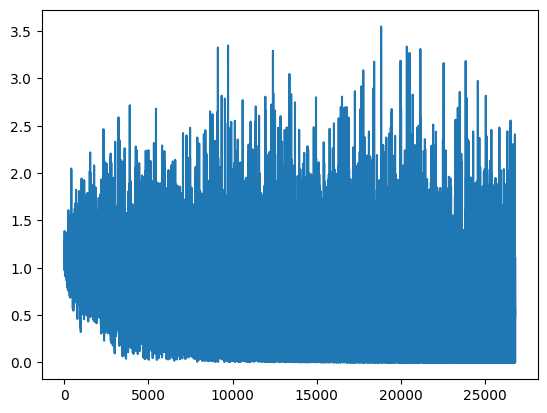

In [35]:
losses = []

prep_model(model_camera, is_camera=True)
plt.plot(losses)

# Submission

In [43]:
dataset_test = MovementDataset(f"{root_path}/test_data.csv")

def collate_test(batch):
    # batch: list of [seq_len x 75] tensors
    data_list, lengths = zip(*batch)
    lengths = torch.tensor(lengths, dtype=torch.long) # (B,)
    data_padded = pad_sequence(data_list, batch_first=True)  # (B, max_seq, 75)
    return data_padded, lengths

test_loader = DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_test
)

In [44]:
df_test = pd.read_csv(f"{root_path}/test_data.csv")
ids = df_test["IDSample"].unique()

In [45]:
subtask1_ans = []
for i in range(len(ids)):
    subtask1_ans.append(dataset_test.len_frames(i))

In [46]:
subtask2_ans, subtask3_ans = [], []

model_action.eval()
model_action.eval()
with torch.no_grad():
    for data, lengths in tqdm(test_loader, desc="Test inference"):
        # move to device
        data, lengths = data.to(device), lengths.to(device)

        # forward once
        logits_cam = model_camera(data, lengths)
        logits_act = model_action(data, lengths)

        # softmax → probabilities
        probs_act = F.softmax(logits_act, dim=-1)  # shape (B,5)
        probs_cam = F.softmax(logits_cam, dim=-1)  # shape (B,3)

        # argmax → class indices
        batch_pred_act = probs_act.argmax(dim=1).cpu().tolist()      # 0–4
        batch_pred_cam = (probs_cam.argmax(dim=1) + 1).cpu().tolist()# 1–3

        subtask2_ans.extend(batch_pred_act)
        subtask3_ans.extend(batch_pred_cam)

Test inference: 100%|██████████| 345/345 [00:03<00:00, 97.95it/s] 


In [47]:
subtask1 = pd.DataFrame({
    "datapointID": ids,
    "answer": subtask1_ans,
    "subtaskID": 1
})

subtask2 = pd.DataFrame({
    "datapointID": ids,
    "answer": subtask2_ans,
    "subtaskID": 2
})

subtask3 = pd.DataFrame({
    "datapointID": ids,
    "answer": subtask3_ans,
    "subtaskID": 3
})

In [48]:
submission = pd.concat([subtask1, subtask2, subtask3])
submission.head()

,datapointID,answer,subtaskID
0,3361,124,1
1,3362,78,1
2,3363,207,1
3,3364,66,1
4,3365,83,1


In [49]:
submission.to_csv("submission.csv", index=False)